In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 4.4MB/s 
     |████████████████████████████████| 1.1MB 24.6MB/s 
     |████████████████████████████████| 890kB 19.2MB/s 
     |████████████████████████████████| 2.9MB 9.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=08afec3f4322586da1b0d5f688b29a90c8cdcdb8812a9eb547e8bdb4744dc3d6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#! cp '/content/drive/My Drive/tweet-sentiment-extraction/preprocessed_train.csv' .
#! cp '/content/drive/My Drive/tweet-sentiment-extraction/preprocessed_test.csv' .
! cp '/content/drive/My Drive/tweet-sentiment-extraction/train.csv' .
! cp '/content/drive/My Drive/tweet-sentiment-extraction/test.csv' .

In [ ]:
#train_df = pd.read_csv('preprocessed_train.csv')
#test_df = pd.read_csv('preprocessed_test.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.shape,test_df.shape

((27481, 4), (3534, 3))

In [ ]:
train_df.sample(10)

,textID,text,selected_text,sentiment
20443,d665b59814,Up a little.. Good luck to tam and robert who ...,Good luck to,positive
1359,fbc0f03d51,oh..keep working on it..you can always make i...,oh..keep working on it..you can always make it...,neutral
16469,6b2dc78496,Thinking about all of the cleaning and organiz...,Thinking about all of the cleaning and organiz...,neutral
26480,af095ef353,How I Met Your Mother? Best show ever,Best,positive
2761,630285dbc7,bored,bored,neutral
17661,e2a149bd12,I`m sitting in altanta. It`s raining in boston...,I`m sitting in altanta. It`s raining in boston...,neutral
21362,c1cf0fdbf5,feels at home to be back at church,feels at home to be back at church,positive
391,47990d2312,BRAINFREEZE,BRAINFREEZE,neutral
2381,fda48cc860,I seriously want a pug Buy me one?,I seriously want a pug Buy me one?,neutral
187,24ee55f264,today was the last day of high school for me a...,sick!,negative


In [ ]:
test_df.sample(5)

,textID,text,sentiment
3164,3ff2b333c3,"I can only imagine, but I know I love hearing...",positive
349,1fee7a1358,Headed home ... Charlie`s at the vet,neutral
3343,b3c6a71077,Getting stressed over a sortie tomorrow. And l...,negative
1187,0996990dca,Cleaning out my room and found this... http://...,neutral
3041,4bcb9c582c,@ Cleaning the house! going out at 3 to see a ...,neutral


In [ ]:
train_df.isnull().sum(),test_df.isnull().sum()

(textID           0
 text             1
 selected_text    1
 sentiment        0
 dtype: int64, textID       0
 text         0
 sentiment    0
 dtype: int64)

In [ ]:
train_df[train_df.text.isna()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [ ]:
train_df.dropna(axis=0,inplace=True)
train_df.shape,test_df.shape

((27480, 4), (3534, 3))

In [ ]:
train_df.duplicated().sum(),test_df.duplicated().sum()

(0, 0)

In [ ]:
train_df.sample(7)

,textID,text,selected_text,sentiment
13796,6d630ebbcb,Happy mother`s day everyone!,Happy mother`s day ev,positive
20167,52aeaf650d,"LOL NOPE, saw a show on TV that claimed so, f...","LOL NOPE, saw a show on TV that claimed so, fi...",neutral
7160,080b93a03d,Go to main settings page for iPhone and scrol...,Go to main settings page for iPhone and scroll...,neutral
17669,7ccecc0245,_m except im on site near the airport on Dixon...,_m except im on site near the airport on Dixon...,neutral
15408,e21a95b747,"woman, follow me","woman, follow me",neutral
4270,b622ed93ab,feels strong contractions but wants to go out....,feels strong contractions but wants to go out....,neutral
25166,a1e6b3b6db,- im hungry...but there`s no food at mah house.,there`s no food,negative


In [ ]:
train_df['text'] = train_df['text'].progress_apply(lambda x : str(x).lower())
train_df['selected_text'] = train_df['selected_text'].progress_apply(lambda x : str(x).lower())

In [ ]:
#https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705
#Reference notebook for Tokenizing ideas

In [ ]:
train_df.sample(10)

,textID,text,selected_text,sentiment
18013,17dfbe1ed9,thanks for having me! i had a great time too,thanks,positive
4822,ba55317637,it wasn`t that good tonight i know dcd thoug...,it wasn`t that good tonight,negative
21529,d2d4deeb43,not funny,not funny,negative
19480,5fd101eebc,why do so many ppl on 12 mile have ashy elbows???,why do so many ppl on 12 mile have ashy elbows???,neutral
9762,6c417fb519,not sure i like this way to learn a new langu...,not sure i like this way to learn a new langua...,neutral
21108,045afd9545,honestly i cannot figure this twitter thing out,honestly i cannot figure this twitter thing out,negative
15913,ed29f08bcd,apparently im not getting drives to school in ...,apparently im not getting drives to school in ...,neutral
9346,6f34b79a49,that wasn`t nice,wasn`t nice,negative
16635,39b583d4b0,woot. just had my interview! went awsome! i di...,awsome!,positive
20045,3275252823,"getting ready to meet laura! than training, e...","getting ready to meet laura! than training, e...",neutral


In [ ]:
train_df[train_df.text=='']

,textID,text,selected_text,sentiment


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val , y_train , y_val = train_test_split(train_df[['text','sentiment']],train_df['selected_text'],test_size=0.2, random_state=42)
x_train.shape, x_val.shape , y_train.shape , y_val.shape

((21984, 2), (5496, 2), (21984,), (5496,))

In [ ]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base',add_prefix_space=True)
tokenizer.encode(' hello world'),tokenizer.encode('hello world')

([0, 20760, 232, 2], [0, 20760, 232, 2])

In [ ]:
MAX_LEN=128
count = x_train.shape[0]
input_ids = np.zeros((count,MAX_LEN),dtype='int32')
attention_mask = np.zeros((count,MAX_LEN),dtype='int32')
start_tokens = np.zeros((count,MAX_LEN),dtype='int32')
end_tokens = np.zeros((count,MAX_LEN),dtype='int32')

In [ ]:
#Understanding tokenizer encode
print(x_train['text'].values[10])
print(x_train['sentiment'].values[10])

v = tokenizer.encode_plus(x_train['text'].values[10],x_train['sentiment'].values[10],add_special_tokens=True,max_length=128,return_attention_mask=True,
                          pad_to_max_length=True,return_tensors='tf',verbose=False)
print(v['input_ids'])
print(v['attention_mask'])

awww the boys have no beards?    i liked their manly man-ness [via ] #asylm
positive
tf.Tensor(
[[    0    10  1401     5  2786    33   117    28  5954   116  1437  1437
   1437   939  6640    49   313   352   313    12  1825   646 11409 27779
    849   281  4360   119     2     2  1313     2     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1]], shape=(1, 128), dtype=int32)
tf.Tensor(
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0

In [ ]:
from tqdm import tqdm
for i,each in tqdm(enumerate(x_train.values)):
  val = tokenizer.encode_plus(each[0],each[1],add_special_tokens=True,max_length=128,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
  input_ids[i] = val['input_ids']
  attention_mask[i] = val['attention_mask']

21984it [00:08, 2624.59it/s]


In [ ]:
# Understanding the concepts of offset and creating start and end tokens
import random
st_tok = np.zeros((1,MAX_LEN),dtype='int32')
end_tok = np.zeros((1,MAX_LEN),dtype='int32')
k  = random.randint(0,x_train.shape[0])
text1 = " "+" ".join(x_train['text'].values[k].split())
text2 = " ".join(y_train.values[k].split())
print(text1)
print(text2)
idx = text1.find(text2)
print(idx)
chars = np.zeros((len(text1)))
chars[idx:idx+len(text2)]=1
if text1[idx-1]==' ':
  chars[idx-1] = 1
print(chars,len(chars))  
enc = tokenizer.encode(text1,add_special_tokens=False)
print(enc)


offsets = []; idx=0
tokens=[]
for t in enc:
  w = tokenizer.decode([t])
  tokens.append(w)
  offsets.append((idx,idx+len(w)))
  idx += len(w)   

print(tokens)
print(offsets)


toks = []
for i,(a,b) in enumerate(offsets):
  sm = np.sum(chars[a:b])
  if sm>0:
    toks.append(i) 
print(toks)

if len(toks)>0:
  st_tok[0,toks[0]+1] = 1
  end_tok[0,toks[-1]+1] = 1 

print('Start tokens',st_tok)
print('End  tokens ',end_tok)

a = np.argmax(st_tok)
b = np.argmax(end_tok)
print(a,b)

text1 = " "+" ".join(x_train['text'].values[k].split())
enc = tokenizer.encode(text1)
st = tokenizer.decode(enc[a:b+1])
print(st)

 haha. not sure what local is to you, but if i was then you`d have to fight me for it!
haha. not sure what local is to you, but if i was then you`d have to fight me for it!
1
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 86
[46116, 4, 45, 686, 99, 400, 16, 7, 47, 6, 53, 114, 939, 21, 172, 47, 12905, 417, 33, 7, 1032, 162, 13, 24, 328]
[' haha', '.', ' not', ' sure', ' what', ' local', ' is', ' to', ' you', ',', ' but', ' if', ' i', ' was', ' then', ' you', '`', 'd', ' have', ' to', ' fight', ' me', ' for', ' it', '!']
[(0, 5), (5, 6), (6, 10), (10, 15), (15, 20), (20, 26), (26, 29), (29, 32), (32, 36), (36, 37), (37, 41), (41, 44), (44, 46), (46, 50), (50, 55), (55, 59), (59, 60), (60, 61), (61, 66), (66, 69), (69, 75), (75, 78), (78, 82), (82, 85), (85, 86)]
[0, 1, 2, 3, 

In [ ]:
from tqdm import tqdm
for k in tqdm(range(x_train.shape[0])):
  text1 = " "+" ".join(x_train['text'].values[k].split())
  text2 = " ".join(y_train.values[k].split())
  idx = text1.find(text2)
  chars = np.zeros((len(text1)))
  chars[idx:idx+len(text2)]=1
  if text1[idx-1]==' ':
    chars[idx-1] = 1
  enc = tokenizer.encode(text1,add_special_tokens=False)



  offsets = []; idx=0
  for t in enc:
    w = tokenizer.decode([t])
    offsets.append((idx,idx+len(w)))
    idx += len(w)   

  toks = []
  for i,(a,b) in enumerate(offsets):
    sm = np.sum(chars[a:b])
    if sm>0:
      toks.append(i) 

  if len(toks)>0:
    start_tokens[k,toks[0]+1] = 1
    end_tokens[k,toks[-1]+1] = 1   

100%|██████████| 21984/21984 [00:09<00:00, 2366.37it/s]


In [ ]:
#Visualize the results
import random

for _ in range(35,50):
  i = random.randint(0,x_train.shape[0])
  print(x_train.iloc[i]['text'])
  print(y_train.values[i])
  print([tokenizer.decode([x]) for x in tokenizer.encode(x_train.iloc[i]['text'])])
  print('Input ids',input_ids[i])
  print('attention mask',attention_mask[i])
  print('Start tokens',start_tokens[i])
  print('end   Tokens',end_tokens[i])
  a = np.argmax(start_tokens[i])
  b=np.argmax(end_tokens[i])
  print(a,b)
  text1 = " "+" ".join(x_train.iloc[i]['text'].split())
  enc = tokenizer.encode(text1)
  st = tokenizer.decode(enc[a:b+1])
  print(st)
  print('*'*50)

 sounds good, the one i was too was also fun
sounds good, the one i was too was also fun
['<s>', ' sounds', ' good', ',', ' the', ' one', ' i', ' was', ' too', ' was', ' also', ' fun', '</s>']
Input ids [   0 4428  205    6    5   65  939   21  350   21   67 1531    2    2
 1313    2    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1]
attention mask [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
MAX_LEN=128
count = y_val.shape[0]
input_ids_val = np.zeros((count,MAX_LEN),dtype='int32')
attention_mask_val = np.zeros((count,MAX_LEN),dtype='int32')
start_tokens_val = np.zeros((count,MAX_LEN),dtype='int32')
end_tokens_val = np.zeros((count,MAX_LEN),dtype='int32')

In [ ]:
from tqdm import tqdm
for i,each in tqdm(enumerate(x_val.values)):
  val = tokenizer.encode_plus(each[0],each[1],add_special_tokens=True,max_length=128,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
  input_ids_val[i] = val['input_ids']
  attention_mask_val[i] = val['attention_mask']

5496it [00:01, 2750.68it/s]


In [ ]:
from tqdm import tqdm
for k in tqdm(range(x_val.shape[0])):
  text1 = " "+" ".join(x_val['text'].values[k].split())
  text2 = " ".join(y_val.values[k].split())
  idx = text1.find(text2)
  chars = np.zeros((len(text1)))
  chars[idx:idx+len(text2)]=1
  if text1[idx-1]==' ':
    chars[idx-1] = 1
  enc = tokenizer.encode(text1,add_special_tokens=False)

  offsets = []; idx=0
  for t in enc:
    w = tokenizer.decode([t])
    offsets.append((idx,idx+len(w)))
    idx += len(w)   

  toks = []
  for i,(a,b) in enumerate(offsets):
    sm = np.sum(chars[a:b])
    if sm>0:
      toks.append(i) 

  if len(toks)>0:
    start_tokens_val[k,toks[0]+1] = 1
    end_tokens_val[k,toks[-1]+1] = 1   

100%|██████████| 5496/5496 [00:02<00:00, 2369.33it/s]


In [ ]:
#Visualize the results
import random

for _ in range(35,50):
  i = random.randint(0,x_val.shape[0])
  print(x_val.iloc[i]['text'])
  print(y_val.values[i])
  print([tokenizer.decode([x]) for x in tokenizer.encode(x_val.iloc[i]['text'])])
  print('Input ids',input_ids_val[i])
  print('attention mask',attention_mask_val[i])
  print('Start tokens',start_tokens_val[i])
  print('end   Tokens',end_tokens_val[i])
  a = np.argmax(start_tokens_val[i])
  b = np.argmax(end_tokens_val[i])
  print(a,b)
  text1 = " "+" ".join(x_val.iloc[i]['text'].split())
  enc = tokenizer.encode(text1)
  st = tokenizer.decode(enc[a:b+1])
  print(st)
  print('*'*50)

i think i`ve finally reached the point in my life where i need a nasal hair trimmer
i think i`ve finally reached the point in my life where i need a nasal hair trimmer
['<s>', ' i', ' think', ' i', '`', 've', ' finally', ' reached', ' the', ' point', ' in', ' my', ' life', ' where', ' i', ' need', ' a', ' nasal', ' hair', ' tr', 'immer', '</s>']
Input ids [    0   939   206   939 12905   548  1747  1348     5   477    11   127
   301   147   939   240    10 35937  2549  2664 15912     2     2  7974
     2     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1    

In [ ]:
from transformers import TFRobertaForQuestionAnswering, TFRobertaModel
roberta = TFRobertaModel.from_pretrained('roberta-base', return_dict=True)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Softmax,Dense,Activation,Dropout

In [ ]:
input1 = Input(shape=(MAX_LEN,),name='input_id',dtype=tf.int32)
input2 = Input(shape=(MAX_LEN,),name='attention_mask',dtype=tf.int32)
bert = roberta(input1,attention_mask = input2)

drop1 = tf.keras.layers.Dropout(0.1)(bert[0]) 
conv1 = tf.keras.layers.Conv1D(1,1)(drop1)
flatten1 = tf.keras.layers.Flatten()(conv1)
x1 = tf.keras.layers.Activation('softmax')(flatten1)
    
drop2 = tf.keras.layers.Dropout(0.1)(bert[0]) 
conv2 = tf.keras.layers.Conv1D(1,1)(drop2)
flatten2 = tf.keras.layers.Flatten()(conv2)
x2 = tf.keras.layers.Activation('softmax')(flatten2)
#dense1 = Dense(units=MAX_LEN,activation='relu',name='dense1',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(start_scores)
#softmax1 = Activation('softmax')(dense1)
#dense2 = Dense(units=MAX_LEN,activation='relu',name='dense2',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(end_scores)
#softmax2 = Activation('softmax')(dense2)

In [ ]:
model = Model(inputs=[input1,input2],outputs=[x1,x2])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_id (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_id[0][0]                   
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 128, 768)     0           tf_roberta_model[0][0]

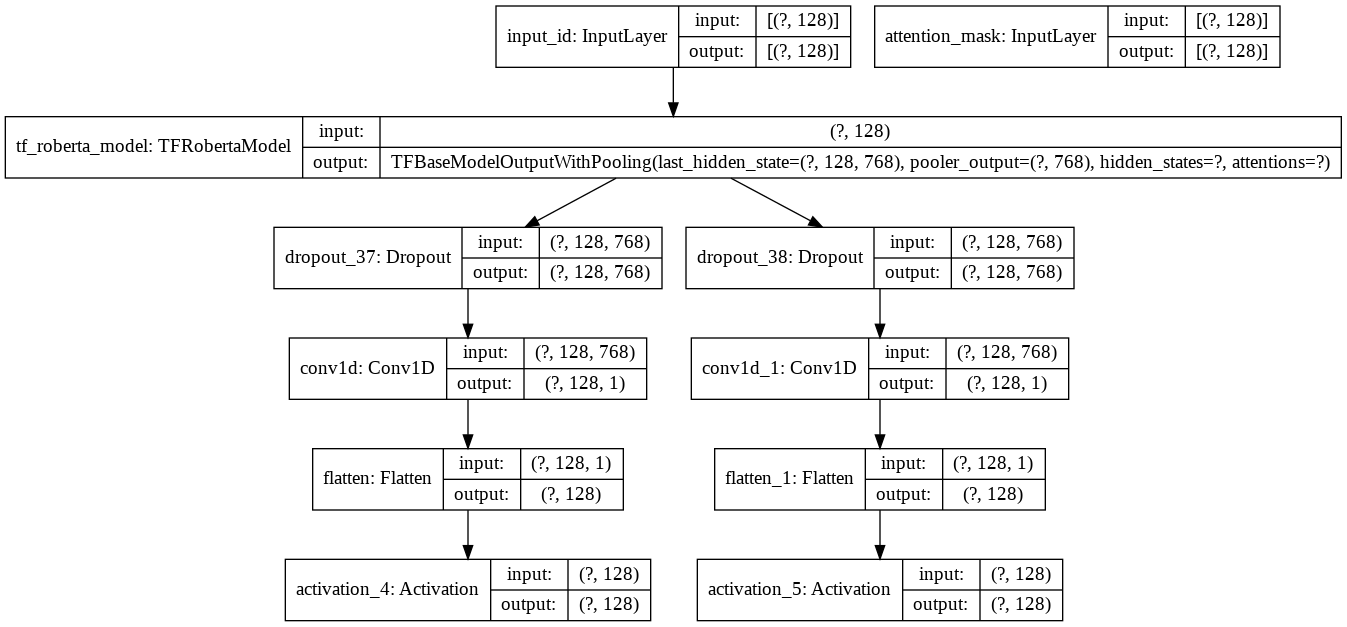

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, 'Model.png',show_shapes=True)

In [ ]:
! rm -r '/content/checkpt'
! rm -r '/content/tensorboard_logs1'

rm: cannot remove '/content/checkpt': No such file or directory
rm: cannot remove '/content/tensorboard_logs1': No such file or directory


In [ ]:
input_data = (input_ids,attention_mask)
output_data = (start_tokens,end_tokens)

val = (input_ids_val,attention_mask_val)
output_val = (start_tokens_val,end_tokens_val)
val_data = (val,output_val)

In [ ]:
%load_ext tensorboard
import datetime
import os
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2,verbose=3,min_lr = 1e-9)
log_dir= os.path.join("tensorboard_logs1" , datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
! mkdir  'checkpt'
file_path = os.path.join('checkpt/model_roberta1.hdf5')
checkpt_save = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,save_weights_only=True,monitor='val_loss',save_best_only=True,verbose=1)
callbacks=[tensorboard_callback,checkpt_save]

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=opt,loss='categorical_crossentropy')
train_dataset = tf.data.Dataset.from_tensor_slices((input_data, output_data)).shuffle(buffer_size=1024).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data).batch(32)

In [ ]:
model.fit(train_dataset,epochs=6,validation_data=val_dataset,callbacks=callbacks)

Epoch 1/6
  1/687 [..............................] - ETA: 0s - loss: 9.6189 - activation_4_loss: 4.9335 - activation_5_loss: 4.6854WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
687/687 [==============================] - ETA: 0s - loss: 2.5032 - activation_4_loss: 1.1568 - activation_5_loss: 1.3464
Epoch 00001: val_loss improved from inf to 1.73524, saving model to checkpt/model_roberta1.hdf5
687/687 [==============================] - 676s 984ms/step - loss: 2.5032 - activation_4_loss: 1.1568 - activation_5_loss: 1.3464 - val_loss: 1.7352 - val_activation_4_loss: 0.8287 - val_activation_5_loss: 0.9065
Epoch 2/6
687/687 [==============================] - ETA: 0s - loss: 1.7265 - activation_4_loss: 0.8493 - activation_5_loss: 0.8772
Epoch 00002: val_loss improv

In [ ]:
! cp -r /content/checkpt '/content/drive/My Drive/tweet-sentiment-extraction'

In [ ]:
model.load_weights('checkpt/model_roberta1.hdf5')

**For training data**

In [ ]:
start , end = model.predict(input_data)
start.shape,end.shape

((21984, 128), (21984, 128))

In [ ]:
pred_values=[]
from tqdm import tqdm
for i in tqdm(range(start.shape[0])):
  a = np.argmax(start[i])
  b = np.argmax(end[i])
  text1 = " "+" ".join(x_train['text'].values[i].split())
  enc = tokenizer.encode(text1)
  val = tokenizer.decode(enc[a:b+1])
  pred_values.append(val)

100%|██████████| 21984/21984 [00:04<00:00, 4504.39it/s]


In [ ]:
x_train['pred_text'] = pred_values
x_train['selected_text'] = y_train.values


In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
scores=[]
for i in tqdm(range(x_train.shape[0])):
  scores.append(jaccard(x_train['pred_text'].values[i],x_train['selected_text'].values[i]))

100%|██████████| 21984/21984 [00:00<00:00, 97724.83it/s]


In [ ]:
x_train['jaccard']=scores

In [ ]:
x_train.head(4)

,text,sentiment,pred_text,selected_text,jaccard
21209,"oh, he`s hilarious. i`m just commenting on th...",positive,hilarious.,hilarious.,1.000000
18265,"thanks for trying i was hoping bud trillin,...",positive,thanks,"thanks for trying i was hoping bud trillin, ...",0.045455
9684,after show at our house rocked! saying goodbye...,neutral,after show at our house rocked! saying goodby...,after show at our house rocked! saying goodbye...,1.000000
9689,up at 4:30am west coast time..gettin ready to ...,positive,excited,soooo excited to go back to my two fav boyzzzz...,0.083333


In [ ]:
print(x_train[x_train.sentiment=='positive']['jaccard'].values.mean())
print(x_train[x_train.sentiment=='negative']['jaccard'].values.mean())
print(x_train[x_train.sentiment=='neutral']['jaccard'].values.mean())

0.6230157892966374
0.6365778855896362
0.9644923251630995


**For Validation data**


In [ ]:
val = (input_ids_val,attention_mask_val)
start_val , end_val = model.predict(val)
start_val.shape,end_val.shape

((5496, 128), (5496, 128))

In [ ]:
pred_values_val=[]
from tqdm import tqdm
for i in tqdm(range(start_val.shape[0])):
  a = np.argmax(start_val[i])
  b = np.argmax(end_val[i])
  text1 = " "+" ".join(x_val['text'].values[i].split())
  enc = tokenizer.encode(text1)
  val = tokenizer.decode(enc[a:b+1])
  pred_values_val.append(val)

100%|██████████| 5496/5496 [00:01<00:00, 4362.88it/s]


In [ ]:
scores_val=[]
x_val['pred_text'] = pred_values_val
x_val['selected_text'] = y_val.values
scores=[]
for i in tqdm(range(x_val.shape[0])):
  scores_val.append(jaccard(x_val['pred_text'].values[i],x_val['selected_text'].values[i]))

x_val['jaccard']=scores_val  

100%|██████████| 5496/5496 [00:00<00:00, 103122.01it/s]


In [ ]:
x_val.sample(20)

,text,sentiment,pred_text,selected_text,jaccard
10496,i would watch if i was at home,neutral,i would watch if i was at home,i would watch if i was at home,1.000000
23199,greetings joan: just wanted to say i still ...,positive,i still miss waking up to your pleasant perso...,ay i still miss waking up to your pleasant per...,0.470588
5036,"awesome, i`m glad you like it. fyi - platinu...",positive,"awesome,",glad,0.000000
24796,going out on thursdays is a terrible idea. i k...,negative,terrible idea.,is a terrible idea. i,0.400000
15003,"if i make some madeleines, i need to have a ba...",neutral,"if i make some madeleines, i need to have a b...","if i make some madeleines, i need to have a ba...",1.000000
24945,getting a cleaning on tues then getting a toot...,negative,ugh.,ugh.,1.000000
26362,oh ok cool will get back to you on that,neutral,oh ok cool will get back to you on that,oh ok cool will get back to you on that,1.000000
24885,sitting at the connection listening to the emp...,negative,mope,mope,1.000000
12548,sky man is quite friendlyand likes joey still...,neutral,sky man is quite friendlyand likes joey still...,sky man is quite friendlyand likes joey still...,1.000000
26304,i`m totally gonna have money to actually buy ...,neutral,i`m totally gonna have money to actually buy ...,i`m totally gonna have money to actually buy a...,1.000000


In [ ]:
print(x_val[x_val.sentiment=='positive']['jaccard'].values.mean())
print(x_val[x_val.sentiment=='negative']['jaccard'].values.mean())
print(x_val[x_val.sentiment=='neutral']['jaccard'].values.mean())

0.5262389243719164
0.5172986994516963
0.9637631215877476


In [ ]:
from transformers import TFRobertaForQuestionAnswering, TFRobertaModel
roberta = TFRobertaModel.from_pretrained('roberta-base', return_dict=True)
roberta.save_pretrained('/content/pretrained')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
! cp -r /content/pretrained_roberta '/content/drive/My Drive/tweet-sentiment-extraction'